## Toy Model : Differential cross-sections in a neutrino exteriment 

Consider the following setup for a generic neutrino experiment: An incoming neutrino beam hits some sort of detector, and in response, a proton and a muon recoil.
![Setup](Image_assets/detector_sketch.jpg)


We want to model this process stochastically (Monte Carlo), given the differential cross-sections: $\frac{d\sigma}{dp_{\mu}}$ and $\frac{d\sigma}{d\cos(\theta_{\mu})}$.

<span style="color: red;">We might consider the angular cross-section in solid angle to be more conventional, i.e., $\frac{d\sigma}{d\Omega}$. In the code, this convention will be adopted.</span>

By considering the differential cross-sections in terms of $\Omega$ rather than $\theta$ or $\cos(\theta)$, it gives a helpful reminder that this problem is in 3D, even though due to azimuthal symmetry $\frac{d\sigma}{d\Omega} = D(\theta)$.

Cross-sections are not neccesarily Probability Distribution Functions (PDFs). 

![Setup](Image_assets/Griffiths_CrossSec.jpg)

The figure above was taken from David Griffiths' Introduction to Elementary Particles Book.

Relating the cross-section to a PDF:

$$p(\theta) = \rho(\theta) d\theta \propto \frac{d \sigma}{d \theta }d \theta
$$

Thus, 

$$ 
\rho(\theta) = C \frac{d \sigma}{d \theta}, 
$$
where $C$ is a normaliation constant. Now, we impose the normalisation condition:

$$
1 = \int_0^{\pi} \rho(\theta) d \theta  = C \int_0^{\pi} \frac{d\sigma}{d \theta} d\theta = C \sigma
$$

Therefore, the PDF is given by:

$$ \rho(\theta) = \frac{1}{\sigma} \frac{d\sigma}{d\theta}  \text{  (BAND)}$$

Very similar calculation shows that:


$$ g(\theta, \phi) = \frac{1}{\sigma} \frac{d\sigma}{d\Omega}  \text{  (POINT)}$$

Therefore, we can use the following procedure to generate random variables compatible to a given differential cross section.


1. Obtain a differential cross-section in terms of the kinematic variables $q_i$.
2. Integrate the differential cross-section to find: $\sigma = \int \frac{d\sigma}{dq_i}dq_i$. (Numerical or Analytic)
3. $PDF = \frac{1}{\sigma} \frac{d\sigma}{dq_i}$.
4. Generate random variables according to the PDF (can be done generically by the **rejection method**, although this is slow, so **'analytic' CDF inversion** wherever possible is preferred).

As a first toy model we shall use:
$$
\frac{d \sigma}{d p_{\mu}} =  N (\mu = 0.5 \text{GeV}, \sigma = 0.1 \text{GeV}),
$$
where N stands for a gaussian distribution.
$$
\frac{d \sigma}{d \cos(\theta_{\mu})} = \cos^2(\theta_{\mu}) \Rightarrow \frac{d \sigma}{ d \Omega} = 2\pi \cos^2(\theta) \Rightarrow \frac{d\sigma}{d \theta} = 2\pi \cos^2(\theta)\sin(\theta)
$$



In [180]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

# d sigma / d Omega 
"""Step 1: Obtianing and enconding some differential cross-section"""
theta = smp.symbols('theta')
dsdo = 2 * smp.pi * smp.cos(theta)**2
dsdt = dsdo * smp.sin(theta)
dsdo

2*pi*cos(theta)**2

In [181]:
"""Step 2: Finding the total cross-section"""
s_o = smp.integrate(dsdo, (theta, 0, smp.pi))
s_o

s_t = smp.integrate(dsdt, (theta, 0, smp.pi)) 
s_t

4*pi/3

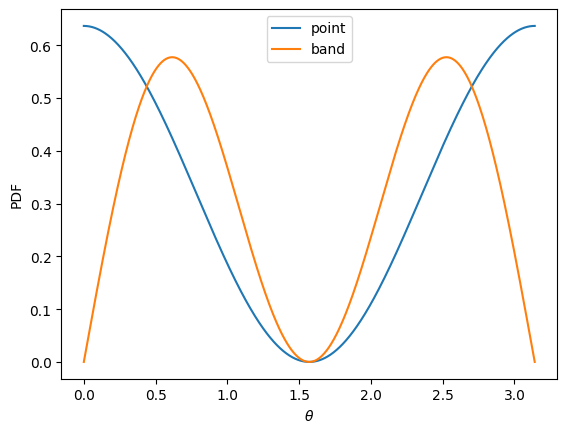

In [182]:
"""Step 3: Normalising PDFs"""
pdf_point = 1 / s_o * dsdo 
pdf_band = 1 / s_t* dsdt

n_pdf_point = smp.lambdify(theta, pdf_point)
n_pdf_band = smp.lambdify(theta, pdf_band)

plt.plot(np.linspace(0, np.pi, 1000), n_pdf_point(np.linspace(0, np.pi, 1000)), label="point")
plt.plot(np.linspace(0, np.pi, 1000), n_pdf_band(np.linspace(0, np.pi, 1000)), label="band")

plt.xlabel(r'$\theta$')
plt.ylabel('PDF')

plt.legend()


In [183]:
pdf_point

2*cos(theta)**2/pi

In [184]:
pdf_band

3*sin(theta)*cos(theta)**2/2

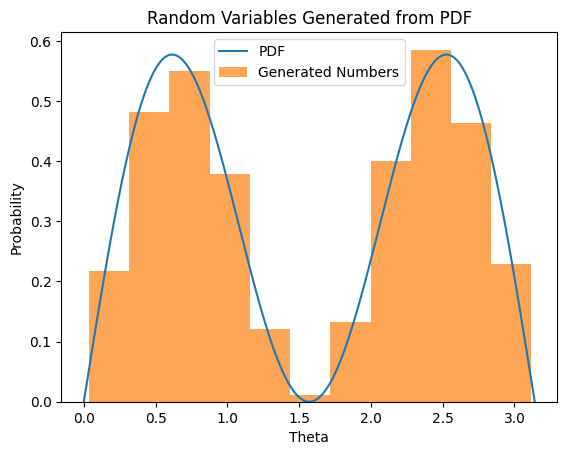

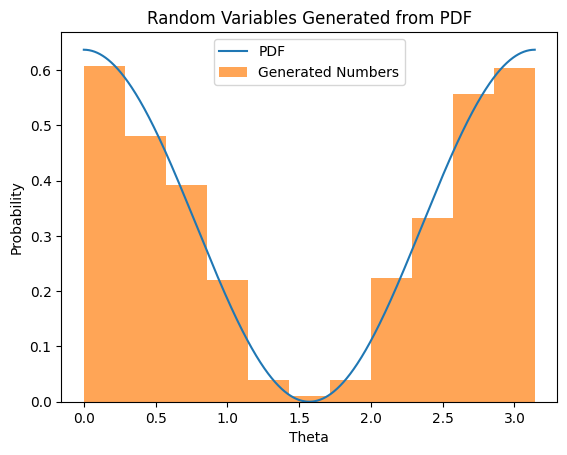

In [187]:
"""Step 4: Generating random Varibles 
(Just a demostration of what happens under the hood, 
not a scalable solution)"""

from scipy.integrate import quad 

#print(quad(n_pdf_band, 0, np.pi))

# why this method works: https://en.wikipedia.org/wiki/Inverse_transform_sampling
# i) Generate random varibles, x according to a uniform dist. between 0 and 1
# ii) Find the cummulative density function (CDF) for the PDF
# iii) Invert the CDF 
# iv) Evalulate CDF^-1 (x), this will be distributed according to the PDF

# Define the symbol and the function

rng = np.random.default_rng(seed=124)


def inv_transf_method(pdf, min_val, max_val, size):
    x = np.linspace(min_val, max_val, 1000)
    pdf = pdf(x)
    cdf = np.cumsum(pdf)  # Compute the cumulative distribution function
    cdf_normalized = cdf / cdf[-1]  # Normalize the CDF

    random_uniform = np.random.random(size)  # Generate random numbers uniformly between 0 and 1
    inverse_cdf = np.interp(random_uniform, cdf_normalized, x)

    return inverse_cdf

theta_min = 0
theta_max = np.pi
theta_arr = np.linspace(theta_min, theta_max, 1000)

rand_band = inv_transf_method(n_pdf_band, theta_min, theta_max, size=1000)
rand_point = inv_transf_method(n_pdf_point, theta_min, theta_max, size=1000)

plt.plot(theta_arr, n_pdf_band(theta_arr), label="PDF")
# Plot the PDF and the generated random variables
plt.hist(rand_band, bins='auto', density=True, alpha=0.7, label='Generated Numbers')
plt.xlabel('Theta')
plt.ylabel('Probability')
plt.title('Random Variables Generated from PDF')
plt.legend()
plt.show()

plt.plot(theta_arr, n_pdf_point(theta_arr), label="PDF")
# Plot the PDF and the generated random variables
plt.hist(rand_point, bins='auto', density=True, alpha=0.7, label='Generated Numbers')
plt.xlabel('Theta')
plt.ylabel('Probability')
plt.title('Random Variables Generated from PDF')
plt.legend()
plt.show()



So far, the way we obtained a PDF form the differential cross-section has proceeded in a more or less adhoc way using sympy, while this is convinient for $\frac{d\sigma}{dq_i}$ with a relatively simple algebraic form we may encounter cross-sectiosn which are not of such a simple form. In the following I encorporate the normalisation into the into the random number generator as well.

In [195]:
import numpy as np
from scipy.integrate import quad

rng = np.random.default_rng(seed=12345)

def inv_transf_rng(f, min_val, max_val, size):
    """Generates random numbers using the inverese transformation method according to any (not neccersaily normalised function of one variable)

    Args:
        f (ufunc): differential cross-section (fuction according to whom random numbers are distributed)
        min_val (float): minimum value of the agument of f
        max_val (float): maximum value of the agument of f
        size (int): number of random variables generated

    Returns:
        ndarray: random numbers distributed according to f
    """
    x = np.linspace(min_val, max_val, 1000)  # Dummy array of the independent varible q_i
    pdf = f(x) / quad(f, min_val, max_val)[0]   # Probability density function 

    cdf = np.cumsum(pdf)  # Cumulative density function
    cdf_norm = cdf / cdf[-1]  # Normalzing the cummulative density function to span a range of [0, 1]

    random_uniform = rng.uniform(0, 1, size)  # Generating random numbers from a uniform distribution

    inverse_cdf = np.interp(random_uniform, cdf_norm, x)  # Inverse of the cumulative density function 

    return inverse_cdf


# can find this function in a separate .py file to be implemented in the neutrino GoF library 

In [202]:
def plotter(f, min_val, max_value, size):
    rand_var = inv_transf_rng(f, min_val, max_val, size)
    
    x = np.linspace(min_val, max_val, 1000)
    pdf = f(x) / quad(f, min_val, max_val)[0]
    
    plt.plot(x, pdf, label = "PDF")
    plt.hist(rand_var, bins='auto', density=True, alpha=0.7, label='Generated Numbers')
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.title('Random Variables Generated from PDF')
    plt.legend()
    plt.show()
    
    

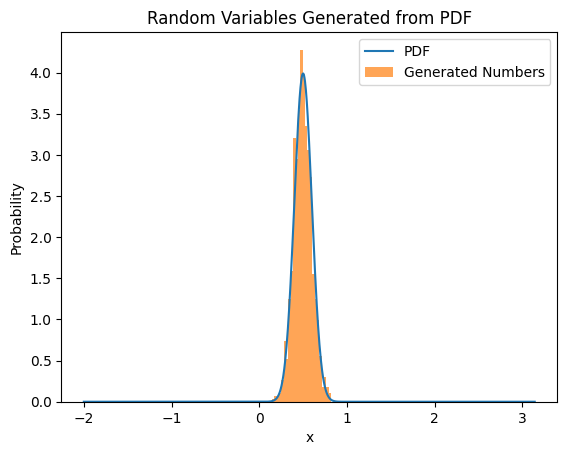

In [223]:
def Gaussian(x):
    mu = 0.5 # [GeV]
    sigma = 0.1 # [GeV]
    normalisation = 1 / (sigma * np.sqrt(2 * np.pi))
    argument = (x - mu) / sigma
    return  normalisation  * np.exp(-0.5 * argument ** 2)


def func(x):
    return Gaussian(x) 


plotter(func, -2 , 3 , 1000)



# Correlation between 2 arrays

Numpy has the bulit in function "numpy.corrcoef", which returns the Pearson product-moment correltation coefficeinet $-1 < R_{ij} < 1$:

$$ R_{ij} = \frac{C_{ij}}{\sqrt{C_{ii} C_{jj}}}$$, 

In [224]:
rand_band = inv_transf_rng(n_pdf_band, 0, np.pi, 1000)
rand_point = inv_transf_rng(n_pdf_point, 0, np.pi, 1000)
rand_gauss = inv_transf_rng(Gaussian, 0, np.pi, 1000)

In [226]:
corr_band_point = np.corrcoef(rand_band, rand_point)
corr_band_point

array([[1.        , 0.04304128],
       [0.04304128, 1.        ]])

In [228]:
corr_band_point = np.corrcoef(rand_point, rand_band)
corr_band_point

array([[1.        , 0.04304128],
       [0.04304128, 1.        ]])

In [229]:
corr_band_point = np.corrcoef(rand_point, rand_gauss)
corr_band_point

array([[ 1.       , -0.0082463],
       [-0.0082463,  1.       ]])

In [230]:
corr_band_point = np.corrcoef(rand_band, rand_gauss)
corr_band_point

array([[1.        , 0.02753848],
       [0.02753848, 1.        ]])

<span style="color: red;">
I am not sure about how to interpret these correlation coefficients, or even if these Pearson correlation coefficients are the right thing to use. Physically the angle $\theta$ and the $p$ must be correlated since they are both a function of the neutrino energy. With that said I do not think that aspect is captured in this toy model, were we to know the actual cross-sections we could make more sense of these correlation coefficients.
</span>